In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.utils.data import DataLoader
import numpy as np 

from models import MnistNet
from utils import train, test
from utils import load_partition, load_data
from flwr.common.parameter import parameters_to_weights
from collections import OrderedDict

import pickle
from matplotlib import pyplot as plt

import glob

In [4]:
DATA_DIR = './datasets/flmnist_iid_2clients'
num_clients = 2
B = 32
# Train loaders for clients
train_sets = [load_partition(cid=x + 1, data_dir=DATA_DIR) for x in range(num_clients)]
_, test_loader = load_data()

/Users/htnu/Research/Flower_FL_examples/utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).type(torch.FloatTensor)


## Load saved global model

In [74]:
tensors = np.load("./save_models/FedAvg_R50_C100_B10_E5_2022-07-21-10:10:18_noniid/last-weights.npz", allow_pickle=True)["arr_0"].tolist()
model = MnistNet()
weights = parameters_to_weights(tensors)
params_dict = zip(model.state_dict().keys(), weights)
state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
model.load_state_dict(state_dict, strict=True)
loss, acc, total = test(model, test_loader, device="mps")

## Load the saved history for plotting

In [3]:
R = 50
C = 100
E = 5

In [4]:
def get_centralized_acc(file_name):
    f = open(file_name, 'rb')
    hist = pickle.load(f)
    f.close()
    accs = hist.metrics_centralized["centralized_acc"]
    accs = [x[1] for x in accs]
    return accs

In [17]:
hist_files = glob.glob(f'save_models/FedOpt/*_R{R}_C{C}*E{E}_*/hist.pkl')
models_accs = list(map(get_centralized_acc, hist_files))
models_names = [x.split('/')[-2].split('_')[0] for x in hist_files]
# models_names = [x.split('_')[0] + " " + x.split('_')[-1] for x in models_names]
models_names

['FedAvg', 'FedAdagrad', 'FedYogi', 'FedAdam']

In [18]:
def acc_info(acc):
    print('Accuracy at the last round: ', acc[-1])
    print('Best Accuracy: ', max(acc), ' at round ', np.argmax(acc))

In [19]:
for name, acc in zip(models_names, models_accs):
    print(name)
    acc_info(acc)

FedAvg
Accuracy at the last round:  0.6438
Best Accuracy:  0.7653  at round  36
FedAdagrad
Accuracy at the last round:  0.6499
Best Accuracy:  0.6499  at round  50
FedYogi
Accuracy at the last round:  0.6811
Best Accuracy:  0.7289  at round  44
FedAdam
Accuracy at the last round:  0.6542
Best Accuracy:  0.6542  at round  50


Text(0, 0.5, 'Accuracy')

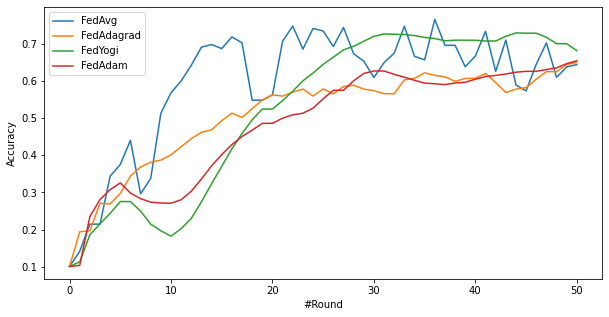

In [20]:
plt.figure(figsize=(10, 5))
for name, acc in zip(models_names, models_accs):
    plt.plot(range(R + 1), acc, label = name)
plt.legend()
plt.xlabel("#Round")
plt.ylabel("Accuracy")